<a href="https://colab.research.google.com/github/theamato/5LN708/blob/master/Copy_of_Assignment_02_Evaluating_and_Extending_an_RNN_based_Part_of_Speech_Tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Evaluating and Extending an RNN based Part-of-Speech Tagger
 
*version 2022.1, details/bugs might be fixed within the first week of publication, you will be notified if this happens*
 
When solving a new problem (or an old problem on a new data set), there are often some "shoulders of giants" to stand on. The first step is to look at the some good papers and try to download someone's code for solving a similar problem to the one you are faced with. The challenge is as much about understanding and adapting already existing code as it is about theoretical knowledge and creativity.
 
For this assignment, you start with a working pipeline for PoS tagging using LSTMs and mini-batch training. Your task is to evaluate the model on a number of sources in different languages. The neural model represents the data's tokens as non-pretrained embedding vectors. The sequences of embedding vectors are passed through a LSTM layer. The outputs from the recurrent layer are then transformed to probabilities over PoS tags by passing them through a fully connected layer and a softmax. You will have to refactor (i.e. rearrange the code) and extend the model by adding some commonly used properties, e.g. the RNN layer type or regularization (see the list of suggestions below).
 
The familiar Brown corpus is used for the reference implementation. This corpus should not be used in your submission.

## Submission
 
Please submit your code as a notebook through studium. You should include the following:
 
1. A working implementation of your pipeline, reproducing your principal results when run. Please ensure that outputs are stored in the notebook (preferably by rerunning your notebook as the last thing you do before submitting).
2. Comment the code properly, especially for longer or opaque functionality. Please try to write self documenting code (e.g. by choosing descriptive variables names, refactoring to isolate functionality, and by minimizing code duplication). This will also help you debug your code.
4. Comments on what you thought was hard in the assignment, what you think was educational, what took most time, and which parts might be unnecessarily tricky.
5. As the submission is anonymous, **all personal information must be removed**.
6. Apart from sections and titles, please remove all unnecessary text and code from the notebook you hand in (e.g., this instuction). Keep only that which strengthens the case that you fulfil the listed requirements.


## Requirements for grade G

To achieve a pass (G) on this assignment, you must solve the following tasks without serious errors.

1. Extend the given model in at least three of the ways listed in the *extensions* section. State clearly which ones you have implemented.
2. Include a short (250-500 words) qualitative analysis in your submission. Discuss the performance difference between languages/genres and design choices. You can spread this in the notebook or put them in one place.
3. Refactor the given model as a class (including relevant preprocessing, forward/backward pass etc). Your model class should follow the sklearn API where possible.
4. Not all languages require the same model complexity for PoS tagging. Some might need a higher dimensionality for the embedding or layers for the model to perform well. Briefly explore the relation between model complexity and accuracy? (Note that the goal is to examine model properties, not to get state-of-the-art accuracy)
5. In your quantitative evaluation, use some genre of text in three languages from the [universal dependencies](https://universaldependencies.org/) project (UD). These will be in the familiar `.conllu` format. Parse the files to get the words (not lemmas).
6. Network accuracy for one model doesn't say much about how well a model performs. Define a baseline accuracy and compare your results to it.
7. The training and testing data must be kept separate. As such, you should find some way of handling out-of-vocabulary words (OOV).


### Additional requirements for grade VG

For a pass with distinction grade (VG), you should extend your analysis to include all the items under *extensions*. State clearly which ones you have done.


### Extensions 
 
1. There are other types of RNNs layers commonly used in NLP. Add the option to use a GRU layer instead of LSTM, and include this in your performance comparison.
2. The given implementation only allows for dependencies from left to right. Add the option to use a bi-directional RNN layer.
3. Use pyTorch's `Dataset` and `DataLoader` classes for loading the data. [This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is a good starting point. This should make it easier to loop over data sets.
4. Try some type of data augmentation in your training data (e.g. masking random tokens). This should theoretically increase the generalizability of your model. How much augmentation is too much?
5. Implement some level of regularization in your model. This can be implemented in several ways, e.g. dropout or weight decay. Briefly argue for the choices you made and show how network preformance might change with the rate of regularization.
6. Add more sources. You can both add sources with different genres and/or more languages. A suggestion is to try how languages with very different levels of morphological richness (e.g. English vs Finish) requires more or less training data. The total number of sources should be above 10.
7. Comment on shortcomings and how to improve the model in relation to a recent POS tagging paper (a good starting point for searching is [NLP-progress](http://nlpprogress.com/).
10. Compare performace using UD's universal vs language specific tag sets.

*Note that trying all combinations of the extensions is not required. It is enough to do some structured testing of extensions and then, for example, go on to compare the tag sets on the best model configuration. This is an exercise in extending and evaluating a model, not in finding the patience to wait for your computer to finish grid searching over alternatives.*


## General advice

The task is to predict, for an unseen review, whether it is positive or negative. This is a binary classification task. Work from the given code and change one piece at a time, ensuring functionality throughout your work. You should test your code every couple of lines to make sure your assumptions on functionality and variable content are correct. A good rule of thumb is that a coder will introduce a bug every five lines (even as a professional).

To make sure your code does what it's supposed to do, use ```assert``` statements to check your assumptions. Keep the given asserts if you need them. Professional coders sometimes start with writing tests for some functionality instead of starting with the functionality itself. This is called *test-driven development*.

Finally, remember the great motto **RTFM**. It will save you in the future.


## Plagiarism
 
In code assignments, plagiarism is a tricky concept. A clean cut way would be to demand that you write all the code yourself, from memory, with only the assigned literature as help. This is not how code is developed professionally. It is common to copy and share. However, since this is a learning exercise, you must implement everything on your own, but please look at the course repo, Stack Overflow etc. Moreover, discuss with course mates and TAs to find inspiration and solutions. Code that is *obviously* copied (with minor modifications) will be considered as plagiarized. As a part of the examination, you might be asked to explain any particular part of the functionality in your implementation.

In [3]:
# Our standard imports for maths and basic methodology
import numpy as np
from sklearn.model_selection import train_test_split

# For user feedback
from tqdm import tqdm
import matplotlib.pyplot as plt

# Imports for pytorch
import torch
import torch.nn as nn

Let's see if we have a GPU.

In [2]:
if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("No GPU available")

Tesla K80


## Load tagging data

The following downloads the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). This data is only here to demonstrate the network below.

In [4]:
#Fredriks part 
import nltk
nltk.download('brown')
from nltk.corpus import brown
nltk.download('universal_tagset')

sentences = brown.tagged_sents(tagset='universal')                        # Load the data
sentences = [sentence for sentence in sentences if len(sentence) > 2]     # Remove very short sentences

print("Loaded %i sentences" % len(sentences))
print(sentences[0])

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
Loaded 56283 sentences
[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


In [5]:
!pip install conllu
#cloning the Arabic github repository
!git clone 'https://github.com/UniversalDependencies/UD_Arabic-PADT.git'


Cloning into 'UD_Arabic-PADT'...
remote: Enumerating objects: 598, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 598 (delta 20), reused 31 (delta 14), pack-reused 560
Receiving objects: 100% (598/598), 121.68 MiB | 24.07 MiB/s, done.
Resolving deltas: 100% (429/429), done.


In [6]:
#cloning the Norwegian bokmaal depository 
!git clone 'https://github.com/UniversalDependencies/UD_Norwegian-Bokmaal.git'

Cloning into 'UD_Norwegian-Bokmaal'...
remote: Enumerating objects: 534, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 534 (delta 48), reused 54 (delta 28), pack-reused 457
Receiving objects: 100% (534/534), 27.48 MiB | 17.75 MiB/s, done.
Resolving deltas: 100% (349/349), done.


In [19]:
#Use pyTorch's Dataset and DataLoader classes for loading the data. 
#This tutorial is a good starting point. This should make it easier to loop over data sets.
import os
from conllu import parse

#Fetching Arabic data  
ara_train = 'UD_Arabic-PADT/ar_padt-ud-test.conllu'
ara_test = 'UD_Arabic-PADT/ar_padt-ud-test.conllu'
with open(ara_train) as infile:
  ara_train_data = infile.readlines()
with open(ara_test) as infile:
  ara_test_data = infile.readlines()

#Fetching Norwegian Bokmaal data
no_train = 'UD_Norwegian-Bokmaal/no_bokmaal-ud-train.conllu'
no_test = 'UD_Norwegian-Bokmaal/no_bokmaal-ud-test.conllu'
with open(no_train) as infile:
  no_train_data = infile.readlines()
with open(no_test) as infile:
  no_test_data = infile.readlines()

def parse_data(data):
  numbers_list = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
  X = []
  y = []
  for lines in data:
    if lines[0] in numbers_list:
      lines = lines.split()
      X.append(lines[1])
      y.append(lines[3])

  assert len(X) == len(y)
  print(X[:10], y[:10])
  return X, y
X_no_train, y_no_train = parse_data(no_train_data)
X_no_test, y_no_test = parse_data(no_test_data)
X_ara_train, y_ara_train = parse_data(ara_train_data)
X_ara_test, y_ara_test = parse_data(ara_test_data)


['Lam', 'og', 'piggvar', 'på', 'bryllupsmenyen', 'Kamskjell', ',', 'piggvar', 'og', 'lammefilet'] ['NOUN', 'CCONJ', 'NOUN', 'SCONJ', 'NOUN', 'NOUN', 'PUNCT', 'NOUN', 'CCONJ', 'NOUN']
['Honnørordene', 'er', '"', 'dristig', 'formspråk', '"', ',', '"', 'nyskapning', '"'] ['NOUN', 'AUX', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT', 'PUNCT', 'PUNCT', 'NOUN', 'PUNCT']
['سوريا', ':', 'تعديل', 'وزاري', 'واسع', 'يشمل', '8', 'حقائب', 'دمشق', '('] ['X', 'PUNCT', 'NOUN', 'ADJ', 'ADJ', 'VERB', 'NUM', 'NOUN', 'X', 'PUNCT']
['سوريا', ':', 'تعديل', 'وزاري', 'واسع', 'يشمل', '8', 'حقائب', 'دمشق', '('] ['X', 'PUNCT', 'NOUN', 'ADJ', 'ADJ', 'VERB', 'NUM', 'NOUN', 'X', 'PUNCT']


Preprocessing for the brow corpus. This splits the data into our standard X and y format.

In [4]:
#Do I need to split my UD- data into x and y? 
X = [[token for token, tag in sentence] for sentence in sentences]
y = [[tag for token, tag in sentence] for sentence in sentences]

assert len(X) == len(y)

print(X[0])
print(y[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(X_train)+len(X_test) == len(X)

print("The training set includes %i sentences" % len(X_train))
print("The test set includes %i sentences" % len(X_test))

NameError: ignored

Most sentences are short, but some are very long.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


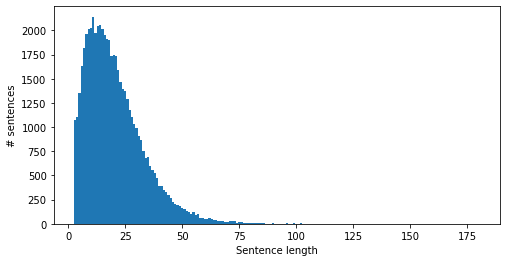

In [6]:
l = np.asarray([len(x) for x in X], dtype=np.int)
plt.figure(figsize=(8, 4))
x = np.unique(l)
plt.bar(x, [np.sum(l==e) for e in x], width=1)
plt.xlabel("Sentence length")
plt.ylabel("# sentences")
plt.show()

## Data encoding and padding

In [17]:
def encode_and_pad(X_train, y_train):
  #tokens = {token for sentence in X_train for token in sentence}
  tokens = X_train
  idx2token = list(tokens)
  idx2token.insert(0, '<UNK>')
  idx2token.append('<PAD>')
  token2idx = {token:idx for idx, token in enumerate(idx2token)}

  #tags = {tag for tags in y_train for tag in tags}
  tags = y_train
  idx2tag = list(tags)
  idx2tag.append('<PAD>')
  tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

  print(idx2token[:15])
  print(idx2tag)

X_no_train, y_no_train = encode_and_pad(X_no_train, y_no_train)
#X_no_test, y_no_test = encode_and_pad(X_no_test, y_no_test)
X_ara_train, y_ara_train = encode_and_pad(X_ara_train, y_ara_train)
#X_ara_test, y_ara_test = parse_data(X_ara_test, y_ara_test)


['<UNK>', 'Lam', 'og', 'piggvar', 'på', 'bryllupsmenyen', 'Kamskjell', ',', 'piggvar', 'og', 'lammefilet', 'sto', 'på', 'menyen', 'under']
['NOUN', 'CCONJ', 'NOUN', 'SCONJ', 'NOUN', 'NOUN', 'PUNCT', 'NOUN', 'CCONJ', 'NOUN', 'VERB', 'ADP', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'CCONJ', 'ADP', 'NOUN', 'PUNCT', 'PROPN', 'X', 'X', 'PROPN', 'PUNCT', 'NOUN', 'VERB', 'NOUN', 'PUNCT', 'PROPN', 'PROPN', 'PROPN', 'PROPN', 'X', 'PROPN', 'PUNCT', 'PUNCT', 'PRON', 'AUX', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'ADP', 'NOUN', 'PUNCT', 'NOUN', 'CCONJ', 'ADJ', 'NOUN', 'PUNCT', 'ADV', 'VERB', 'PUNCT', 'PROPN', 'X', 'PROPN', 'PUNCT', 'X', 'X', 'X', 'PUNCT', 'PUNCT', 'PRON', 'AUX', 'ADJ', 'NOUN', 'VERB', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'NOUN', 'VERB', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'CCONJ', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'CCONJ', 'NOUN', 'PUNCT', 'NOUN', 'AUX', 'PUNCT', 'PROPN', 'X', 'PUNCT', 'X', 'X', 'X', 'X', 'PUNCT', 'PUNCT', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'ADJ', 'NOUN', 'ADP', 'N

TypeError: ignored

In [20]:
def pad_and_encode(sentences, labels):
  assert len(sentences)==len(labels)
  assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
  max_sentence_length = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
  padded_sentences = torch.zeros(len(sentences), max_sentence_length,     # Create data structures with <PAD> as default
                                 dtype=torch.long)
  padded_sentences[:] = token2idx['<PAD>']
  padded_labels = torch.zeros(len(sentences), max_sentence_length, 
                              dtype=torch.long)
  padded_labels[:] = tag2idx['<PAD>']
  for i, (sentence, tags) in enumerate(zip(sentences, labels)):               # Loop over the data
    for j, token in enumerate(sentence):
      if token in token2idx.keys():
        padded_sentences[i, j] = token2idx[token]
      else:
        padded_sentences[i, j] = token2idx['<UNK>']
    for j, tag in enumerate(tags):
      padded_labels[i, j] = tag2idx[tag]
  return padded_sentences, padded_labels

a, b = pad_and_encode(X_no_train[:5], y_no_train[:5])
print(a)
print(b)

AssertionError: ignored

In [9]:
def batch_iterator(sentences, labels, batch_size=64):
  """Helper function for iterating over batches of the data"""
  assert len(sentences) == len(labels)
  for i in range(0, len(sentences), batch_size):
    X, y = pad_and_encode(sentences[i:min(i+batch_size, len(sentences))], 
                          labels[i:min(i+batch_size, len(sentences))])
    if torch.cuda.is_available():                                               # Move data to the GPU, if possible, before yielding it
      yield (X.cuda(), y.cuda())
    else:
      yield (X, y)

next(batch_iterator(X_train, y_train, batch_size=5))

(tensor([[50135, 18102, 10350, 36498, 53204,  1237, 37363, 14886, 22807, 38303,
          37363, 14886, 51607, 37363, 48560, 48132, 29537, 53337, 53337, 53337,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
         [49268,  6535, 21610, 21837, 27619, 29863, 43815,  4342, 18243, 14549,
          36395, 45679, 21610, 46699, 13227, 31114, 43815, 46392, 18243, 15832,
          15768, 40761, 19048,   867, 26623, 37363, 31114, 42619, 29537],
         [44115,  3477,  3205, 30387, 46699, 18222, 50641, 21610, 34316, 43485,
          34316, 44115, 34794,  4547, 29537, 53337, 53337, 53337, 53337, 53337,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
         [44741, 53136, 11694,  9606, 46699, 22239, 53136, 11694,  9254, 29537,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
         [37870, 45610, 14886,  5268, 21610, 45610, 14886, 48475

## Model

In [10]:
class LSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, lstm_hidden_dim, vocabulary_size, tagset_size, bidirectional):
    """An LSTM based tagger
    
    word_embedding_dim
      The dimensionality of the word embedding
    lstm_hidden_dim
      The dimensionality of the hidden state in the LSTM
    vocabulary_size
      The number of unique tokens in the word embedding (including <PAD> etc)
    tagset_size
      The number of unique POS tags (not including <PAD>, as we don't want to predict it)
    """
    super(LSTMTagger, self).__init__()                                          # We need to initialise the class we are inheriting from
    self.lstm_hidden_dim_ = lstm_hidden_dim*2                                     # This simply stores the parameters
    self.vocabulary_size_ = vocabulary_size
    self.tagset_size_ = tagset_size

    self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,         # Creates the vector space for the input words
                                         embedding_dim=word_embedding_dim, 
                                         padding_idx=token2idx['<PAD>'])
    self._lstm = nn.LSTM(input_size=word_embedding_dim,                         # The LSTM takes an embedded sentence as input, and outputs 
                         hidden_size=lstm_hidden_dim,                           # vectors with dimensionality lstm_hidden_dim.
                         batch_first=True)
    self._fc = nn.Linear(lstm_hidden_dim, tagset_size)                          # The linear layer maps from the RNN output space to tag space
    self._softmax = nn.LogSoftmax(dim=1)                                        # Softmax of outputting PDFs over tags
    
    self.training_loss_ = list()                                                # For plotting
    self.training_accuracy_ = list()

    if torch.cuda.is_available():                                               # Move the model to the GPU (if we have one)
      self.cuda()

  def forward(self, padded_sentences):
    """The forward pass through the network"""
    batch_size, max_sentence_length = padded_sentences.size()

    embedded_sentences = self._word_embedding(padded_sentences)                 # Sentences encoded as integers are mapped to vectors    

    sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)        # Find the length of sentences
    sentence_lengths = sentence_lengths.long().cpu()                            # Ensure the correct format
    X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                          batch_first=True, enforce_sorted=False)
    lstm_out, _ = self._lstm(X)                                                 # Run the LSTM layer
    X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)         # Unpack the output from the LSTM

    X = X.contiguous().view(-1, X.shape[2])                                     # The output from the LSTM layer is flattened
    tag_space = self._fc(X)                                                     # Fully connected layer
    tag_scores = self._softmax(tag_space)     
    return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)                                  # Softmax is applied to normalise the outputs

  # Task 2: Adding the option to use a bi-directional RNN layer.
  def backward(self, padded_sentences):
    """My source https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html"""
    
    batch_size, max_sentence_length = padded_sentences.size()

    embedded_sentences = self._word_embedding(padded_sentences)                 # Sentences encoded as integers are mapped to vectors    

    sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)        # Find the length of sentences
    sentence_lengths = sentence_lengths.long().cpu()                            # Ensure the correct format
    X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                          batch_first=True, enforce_sorted=False)
    lstm_out, _ = self._lstm(X)                                                 # Run the LSTM layer
    X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)         # Unpack the output from the LSTM

    X = X.contiguous().view(-1, X.shape[2])                                     # The output from the LSTM layer is flattened
    tag_space = self._fc(X)                                                     # Fully connected layer
    tag_scores = self._softmax(tag_space)                                       # Softmax is applied to normalise the outputs

    return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)


model = LSTMTagger(word_embedding_dim=32,                                       # Dimensionality of the work embedding
                   lstm_hidden_dim=64,                                          # Dimensionality of the hidden state in the LSTM
                   vocabulary_size=len(token2idx),                              # The vocabulary incudes both the 'padding' and 'unknown' symbols
                   tagset_size=len(tag2idx)-1, bidirectional = True)                                  # We have no interest in the network outputting the padding symbol
print(model)

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


## Network training

In [11]:
loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])
#print(loss_function)                       # A loss function that fits our choice of output layer and data. The
                                                                                # loss function will ignore the padding index in the targets.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)                                # We give the optimiser the parameters to work with, note that we can choose to only give some parameters

batch_size = 256                                                                # Define the size of each batch
for epoch in range(5):                                                          # Times to loop over the full dataset
  with tqdm(batch_iterator(X_train, y_train, batch_size=batch_size), 
            total=len(X_train)//batch_size+1, unit="batch", desc="Epoch %i" % epoch) as batches:
    for inputs, targets in batches:
      print(model)                                         # Loop once over the training data
      model.zero_grad()                                                         # Reset gradients
      scores = model(inputs)  
      h = model.forward(inputs)                                                 # Forward pass
      loss = loss_function(scores.view(-1, model.tagset_size_),                 # Get loss, the data is reshaped as a long line of predictions and targets
                           targets.view(-1))
                  
      loss.backward()                                                           # Backpropagate the error
      optimizer.step()                                                          # Run the optimizer to change the weights w.r.t the loss
      predictions = scores.argmax(dim=2, keepdim=True).squeeze()                # Calculate the batch training accuracy
      mask = targets!=tag2idx['<PAD>']                                          # Create a mask for ignoring <PAD> in the targets
      correct = (predictions[mask] == targets[mask]).sum().item()               # Item pulls the value from the GPU automatically (if needed)
      accuracy = correct / mask.sum().item()*100
      model.training_accuracy_.append(accuracy)                                 # Save the accuracy for plotting
      model.training_loss_.append(loss.item())                                  # Save the loss for plotting
      batches.set_postfix(loss=loss.item(), accuracy=accuracy)                  # Update the progress bar

Epoch 0:   0%|          | 0/198 [00:00<?, ?batch/s]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:   2%|▏         | 3/198 [00:00<00:20,  9.32batch/s, accuracy=36.9, loss=2.22]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:   4%|▎         | 7/198 [00:00<00:15, 12.21batch/s, accuracy=34.2, loss=1.98]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:   5%|▍         | 9/198 [00:00<00:15, 12.32batch/s, accuracy=46.1, loss=1.77]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:   7%|▋         | 13/198 [00:01<00:14, 13.05batch/s, accuracy=50, loss=1.59]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:   8%|▊         | 15/198 [00:01<00:14, 12.93batch/s, accuracy=55, loss=1.42]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  10%|▉         | 19/198 [00:01<00:13, 13.69batch/s, accuracy=58, loss=1.27]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  10%|▉         | 19/198 [00:01<00:13, 13.69batch/s, accuracy=60.2, loss=1.22]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  11%|█         | 21/198 [00:02<00:18,  9.38batch/s, accuracy=62.9, loss=1.14]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  13%|█▎        | 25/198 [00:02<00:16, 10.38batch/s, accuracy=64.7, loss=1.09]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  14%|█▎        | 27/198 [00:02<00:15, 11.18batch/s, accuracy=69.1, loss=0.966]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  16%|█▌        | 31/198 [00:02<00:13, 12.52batch/s, accuracy=70.3, loss=0.882]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  17%|█▋        | 33/198 [00:02<00:13, 12.50batch/s, accuracy=73, loss=0.825]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  19%|█▊        | 37/198 [00:03<00:11, 13.83batch/s, accuracy=73.8, loss=0.804]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  21%|██        | 41/198 [00:03<00:11, 13.87batch/s, accuracy=77.5, loss=0.687]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  22%|██▏       | 43/198 [00:03<00:11, 13.64batch/s, accuracy=77.4, loss=0.674]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  24%|██▎       | 47/198 [00:03<00:10, 14.20batch/s, accuracy=78.3, loss=0.644]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  26%|██▌       | 51/198 [00:04<00:10, 14.41batch/s, accuracy=80.2, loss=0.595]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  27%|██▋       | 53/198 [00:04<00:10, 14.23batch/s, accuracy=81.4, loss=0.578]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  29%|██▉       | 57/198 [00:04<00:09, 14.29batch/s, accuracy=81.4, loss=0.562]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  30%|██▉       | 59/198 [00:04<00:09, 14.20batch/s, accuracy=82.5, loss=0.533]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  32%|███▏      | 63/198 [00:04<00:09, 14.35batch/s, accuracy=83.6, loss=0.511]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  33%|███▎      | 65/198 [00:05<00:09, 14.17batch/s, accuracy=83.2, loss=0.513]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  35%|███▍      | 69/198 [00:05<00:09, 13.98batch/s, accuracy=85.1, loss=0.464]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  36%|███▌      | 71/198 [00:05<00:08, 14.20batch/s, accuracy=85.3, loss=0.45] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  38%|███▊      | 75/198 [00:05<00:08, 14.39batch/s, accuracy=85.9, loss=0.423]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  39%|███▉      | 77/198 [00:05<00:08, 14.54batch/s, accuracy=86.5, loss=0.406]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  41%|████      | 81/198 [00:06<00:08, 14.58batch/s, accuracy=87.2, loss=0.401]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  43%|████▎     | 85/198 [00:06<00:08, 13.84batch/s, accuracy=86.9, loss=0.391]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  44%|████▍     | 87/198 [00:06<00:08, 13.78batch/s, accuracy=87, loss=0.384]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  46%|████▌     | 91/198 [00:06<00:07, 14.33batch/s, accuracy=88.6, loss=0.373]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  47%|████▋     | 93/198 [00:07<00:07, 14.12batch/s, accuracy=88.5, loss=0.372]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  49%|████▉     | 97/198 [00:07<00:07, 14.03batch/s, accuracy=88.5, loss=0.348]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  50%|█████     | 99/198 [00:07<00:07, 13.85batch/s, accuracy=89.2, loss=0.342]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  52%|█████▏    | 103/198 [00:07<00:06, 14.01batch/s, accuracy=89.5, loss=0.313]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  53%|█████▎    | 105/198 [00:07<00:06, 14.07batch/s, accuracy=90.1, loss=0.312]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  55%|█████▌    | 109/198 [00:08<00:06, 13.80batch/s, accuracy=89.8, loss=0.314]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  56%|█████▌    | 111/198 [00:08<00:06, 13.78batch/s, accuracy=90.2, loss=0.304]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  58%|█████▊    | 115/198 [00:08<00:05, 14.29batch/s, accuracy=90.1, loss=0.306]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  60%|██████    | 119/198 [00:08<00:05, 14.37batch/s, accuracy=90.6, loss=0.291]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  61%|██████    | 121/198 [00:09<00:05, 14.16batch/s, accuracy=90.8, loss=0.29]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  63%|██████▎   | 125/198 [00:09<00:05, 14.51batch/s, accuracy=90.3, loss=0.295]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  64%|██████▍   | 127/198 [00:09<00:05, 13.97batch/s, accuracy=91.3, loss=0.263]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  66%|██████▌   | 131/198 [00:09<00:04, 14.52batch/s, accuracy=91.4, loss=0.267]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  68%|██████▊   | 135/198 [00:10<00:04, 14.24batch/s, accuracy=91.1, loss=0.27]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  69%|██████▉   | 137/198 [00:10<00:04, 14.29batch/s, accuracy=91.6, loss=0.258]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  71%|███████   | 141/198 [00:10<00:04, 14.04batch/s, accuracy=91, loss=0.262]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  73%|███████▎  | 145/198 [00:10<00:03, 13.94batch/s, accuracy=91.7, loss=0.248]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  74%|███████▍  | 147/198 [00:10<00:03, 13.89batch/s, accuracy=91.8, loss=0.249]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  76%|███████▋  | 151/198 [00:11<00:03, 13.86batch/s, accuracy=91.9, loss=0.245]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  77%|███████▋  | 153/198 [00:11<00:03, 14.07batch/s, accuracy=92.1, loss=0.243]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  79%|███████▉  | 157/198 [00:11<00:02, 13.85batch/s, accuracy=92.2, loss=0.226]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  80%|████████  | 159/198 [00:11<00:02, 13.90batch/s, accuracy=92.4, loss=0.24] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  82%|████████▏ | 163/198 [00:12<00:02, 14.02batch/s, accuracy=92.1, loss=0.223]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  83%|████████▎ | 165/198 [00:12<00:02, 13.95batch/s, accuracy=92.6, loss=0.217]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  85%|████████▌ | 169/198 [00:12<00:02, 14.05batch/s, accuracy=92.6, loss=0.212]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  86%|████████▋ | 171/198 [00:12<00:01, 13.72batch/s, accuracy=92.3, loss=0.23] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  88%|████████▊ | 175/198 [00:12<00:01, 13.87batch/s, accuracy=93.4, loss=0.203]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  89%|████████▉ | 177/198 [00:13<00:01, 14.19batch/s, accuracy=92.6, loss=0.218]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  91%|█████████▏| 181/198 [00:13<00:01, 14.10batch/s, accuracy=92.8, loss=0.222]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  92%|█████████▏| 183/198 [00:13<00:01, 14.16batch/s, accuracy=92.8, loss=0.211]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  94%|█████████▍| 187/198 [00:13<00:00, 14.23batch/s, accuracy=93.2, loss=0.205]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  95%|█████████▌| 189/198 [00:13<00:00, 14.19batch/s, accuracy=93.2, loss=0.209]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  97%|█████████▋| 193/198 [00:14<00:00, 14.13batch/s, accuracy=92.9, loss=0.213]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0:  98%|█████████▊| 195/198 [00:14<00:00, 14.18batch/s, accuracy=92.8, loss=0.212]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 0: 100%|██████████| 198/198 [00:14<00:00, 13.62batch/s, accuracy=92.8, loss=0.21]


LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   0%|          | 0/198 [00:00<?, ?batch/s, accuracy=93.4, loss=0.198]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   1%|          | 2/198 [00:00<00:13, 14.02batch/s, accuracy=94.1, loss=0.182]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   2%|▏         | 4/198 [00:00<00:13, 14.09batch/s, accuracy=93.8, loss=0.187]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   3%|▎         | 6/198 [00:00<00:13, 14.36batch/s, accuracy=93, loss=0.214]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   3%|▎         | 6/198 [00:00<00:13, 14.36batch/s, accuracy=93.8, loss=0.192]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   4%|▍         | 8/198 [00:00<00:14, 13.35batch/s, accuracy=93.8, loss=0.179]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   5%|▌         | 10/198 [00:00<00:14, 13.36batch/s, accuracy=93.2, loss=0.191]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   6%|▌         | 12/198 [00:00<00:13, 13.48batch/s, accuracy=93.7, loss=0.191]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   6%|▌         | 12/198 [00:00<00:13, 13.48batch/s, accuracy=94.2, loss=0.179]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   7%|▋         | 14/198 [00:01<00:13, 13.21batch/s, accuracy=93.6, loss=0.187]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   8%|▊         | 16/198 [00:01<00:13, 13.34batch/s, accuracy=93.4, loss=0.198]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   9%|▉         | 18/198 [00:01<00:13, 13.59batch/s, accuracy=94.6, loss=0.175]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:   9%|▉         | 18/198 [00:01<00:13, 13.59batch/s, accuracy=93.6, loss=0.191]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  10%|█         | 20/198 [00:01<00:13, 13.24batch/s, accuracy=94.4, loss=0.169]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  11%|█         | 22/198 [00:01<00:13, 12.91batch/s, accuracy=93.5, loss=0.19]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  12%|█▏        | 24/198 [00:01<00:13, 13.23batch/s, accuracy=94.1, loss=0.178]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  12%|█▏        | 24/198 [00:01<00:13, 13.23batch/s, accuracy=93.4, loss=0.202]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  13%|█▎        | 26/198 [00:02<00:13, 12.77batch/s, accuracy=93.8, loss=0.187]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  14%|█▍        | 28/198 [00:02<00:12, 13.12batch/s, accuracy=93.4, loss=0.188]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  15%|█▌        | 30/198 [00:02<00:12, 13.09batch/s, accuracy=93.6, loss=0.192]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  15%|█▌        | 30/198 [00:02<00:12, 13.09batch/s, accuracy=94.7, loss=0.157]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  16%|█▌        | 32/198 [00:02<00:12, 12.95batch/s, accuracy=94.3, loss=0.172]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  17%|█▋        | 34/198 [00:02<00:12, 13.08batch/s, accuracy=93.7, loss=0.183]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  18%|█▊        | 36/198 [00:02<00:12, 13.31batch/s, accuracy=94, loss=0.197]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  18%|█▊        | 36/198 [00:02<00:12, 13.31batch/s, accuracy=93.4, loss=0.213]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  19%|█▉        | 38/198 [00:02<00:11, 13.71batch/s, accuracy=94.5, loss=0.165]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  20%|██        | 40/198 [00:02<00:11, 13.63batch/s, accuracy=94.2, loss=0.167]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  21%|██        | 42/198 [00:03<00:11, 13.46batch/s, accuracy=94.1, loss=0.184]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  21%|██        | 42/198 [00:03<00:11, 13.46batch/s, accuracy=94.5, loss=0.172]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  22%|██▏       | 44/198 [00:03<00:11, 13.09batch/s, accuracy=94.5, loss=0.155]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  23%|██▎       | 46/198 [00:03<00:11, 13.36batch/s, accuracy=94.5, loss=0.156]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  24%|██▍       | 48/198 [00:03<00:11, 13.53batch/s, accuracy=94.2, loss=0.174]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  24%|██▍       | 48/198 [00:03<00:11, 13.53batch/s, accuracy=94.8, loss=0.157]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  25%|██▌       | 50/198 [00:03<00:10, 13.50batch/s, accuracy=94.3, loss=0.166]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  26%|██▋       | 52/198 [00:03<00:10, 13.61batch/s, accuracy=94.2, loss=0.174]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  27%|██▋       | 54/198 [00:04<00:10, 13.22batch/s, accuracy=94.4, loss=0.176]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  27%|██▋       | 54/198 [00:04<00:10, 13.22batch/s, accuracy=94.9, loss=0.156]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  28%|██▊       | 56/198 [00:04<00:10, 13.30batch/s, accuracy=94.4, loss=0.16] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  29%|██▉       | 58/198 [00:04<00:10, 13.54batch/s, accuracy=94.1, loss=0.169]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  30%|███       | 60/198 [00:04<00:10, 13.62batch/s, accuracy=94.7, loss=0.162]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  30%|███       | 60/198 [00:04<00:10, 13.62batch/s, accuracy=94.3, loss=0.162]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  31%|███▏      | 62/198 [00:04<00:10, 13.40batch/s, accuracy=94.5, loss=0.161]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  32%|███▏      | 64/198 [00:04<00:10, 13.38batch/s, accuracy=94.7, loss=0.161]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  33%|███▎      | 66/198 [00:04<00:09, 13.37batch/s, accuracy=94.7, loss=0.166]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  33%|███▎      | 66/198 [00:05<00:09, 13.37batch/s, accuracy=95.1, loss=0.14] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  34%|███▍      | 68/198 [00:05<00:09, 13.45batch/s, accuracy=94.7, loss=0.147]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  35%|███▌      | 70/198 [00:05<00:09, 13.43batch/s, accuracy=94.6, loss=0.152]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  36%|███▋      | 72/198 [00:05<00:09, 13.50batch/s, accuracy=95.2, loss=0.14]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  36%|███▋      | 72/198 [00:05<00:09, 13.50batch/s, accuracy=94.9, loss=0.153]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  37%|███▋      | 74/198 [00:05<00:09, 13.46batch/s, accuracy=95.2, loss=0.141]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  38%|███▊      | 76/198 [00:05<00:08, 13.64batch/s, accuracy=94.5, loss=0.16]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  39%|███▉      | 78/198 [00:05<00:08, 13.72batch/s, accuracy=94.9, loss=0.141]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  39%|███▉      | 78/198 [00:05<00:08, 13.72batch/s, accuracy=94.6, loss=0.152]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  40%|████      | 80/198 [00:06<00:08, 13.71batch/s, accuracy=95.5, loss=0.135]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  41%|████▏     | 82/198 [00:06<00:08, 13.51batch/s, accuracy=94.9, loss=0.147]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  42%|████▏     | 84/198 [00:06<00:08, 13.28batch/s, accuracy=95, loss=0.15]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  42%|████▏     | 84/198 [00:06<00:08, 13.28batch/s, accuracy=95.2, loss=0.146]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  43%|████▎     | 86/198 [00:06<00:08, 13.05batch/s, accuracy=94.8, loss=0.148]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  44%|████▍     | 88/198 [00:06<00:08, 13.29batch/s, accuracy=95, loss=0.15]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  45%|████▌     | 90/198 [00:06<00:08, 13.42batch/s, accuracy=95.7, loss=0.137]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  45%|████▌     | 90/198 [00:06<00:08, 13.42batch/s, accuracy=95.2, loss=0.154]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  46%|████▋     | 92/198 [00:06<00:08, 13.19batch/s, accuracy=95.2, loss=0.146]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  47%|████▋     | 94/198 [00:07<00:07, 13.32batch/s, accuracy=94.7, loss=0.157]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  48%|████▊     | 96/198 [00:07<00:07, 12.93batch/s, accuracy=95.6, loss=0.131]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  48%|████▊     | 96/198 [00:07<00:07, 12.93batch/s, accuracy=95.5, loss=0.135]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  49%|████▉     | 98/198 [00:07<00:07, 12.96batch/s, accuracy=96.1, loss=0.119]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  51%|█████     | 100/198 [00:07<00:07, 13.07batch/s, accuracy=95.4, loss=0.144]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  52%|█████▏    | 102/198 [00:07<00:07, 13.22batch/s, accuracy=95.5, loss=0.135]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  52%|█████▏    | 102/198 [00:07<00:07, 13.22batch/s, accuracy=95.5, loss=0.13] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  53%|█████▎    | 104/198 [00:07<00:07, 13.24batch/s, accuracy=95.2, loss=0.141]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  54%|█████▎    | 106/198 [00:07<00:07, 12.96batch/s, accuracy=95.9, loss=0.121]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  55%|█████▍    | 108/198 [00:08<00:06, 12.94batch/s, accuracy=94.8, loss=0.139]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  55%|█████▍    | 108/198 [00:08<00:06, 12.94batch/s, accuracy=95.9, loss=0.133]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  56%|█████▌    | 110/198 [00:08<00:06, 13.31batch/s, accuracy=95.4, loss=0.133]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  57%|█████▋    | 112/198 [00:08<00:06, 13.32batch/s, accuracy=95.5, loss=0.134]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  58%|█████▊    | 114/198 [00:08<00:06, 13.53batch/s, accuracy=95.9, loss=0.125]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  58%|█████▊    | 114/198 [00:08<00:06, 13.53batch/s, accuracy=95.1, loss=0.142]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  59%|█████▊    | 116/198 [00:08<00:05, 13.68batch/s, accuracy=95.8, loss=0.119]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  60%|█████▉    | 118/198 [00:08<00:05, 13.69batch/s, accuracy=95.2, loss=0.136]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  61%|██████    | 120/198 [00:08<00:05, 13.45batch/s, accuracy=95.1, loss=0.138]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  61%|██████    | 120/198 [00:09<00:05, 13.45batch/s, accuracy=95.8, loss=0.131]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  62%|██████▏   | 122/198 [00:09<00:05, 13.32batch/s, accuracy=95.2, loss=0.136]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  63%|██████▎   | 124/198 [00:09<00:05, 13.59batch/s, accuracy=96, loss=0.118]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  64%|██████▎   | 126/198 [00:09<00:05, 13.90batch/s, accuracy=95.6, loss=0.129]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  64%|██████▎   | 126/198 [00:09<00:05, 13.90batch/s, accuracy=95.4, loss=0.142]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  65%|██████▍   | 128/198 [00:09<00:05, 13.69batch/s, accuracy=95.5, loss=0.129]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  66%|██████▌   | 130/198 [00:09<00:04, 13.89batch/s, accuracy=95.5, loss=0.125]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  67%|██████▋   | 132/198 [00:09<00:04, 13.81batch/s, accuracy=95.2, loss=0.139]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  67%|██████▋   | 132/198 [00:09<00:04, 13.81batch/s, accuracy=95.9, loss=0.126]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  68%|██████▊   | 134/198 [00:10<00:04, 13.43batch/s, accuracy=95.6, loss=0.132]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  69%|██████▊   | 136/198 [00:10<00:04, 13.26batch/s, accuracy=95.6, loss=0.137]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  70%|██████▉   | 138/198 [00:10<00:04, 13.63batch/s, accuracy=95.3, loss=0.13]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  70%|██████▉   | 138/198 [00:10<00:04, 13.63batch/s, accuracy=95.2, loss=0.135]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  71%|███████   | 140/198 [00:10<00:04, 13.40batch/s, accuracy=95.7, loss=0.12] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  72%|███████▏  | 142/198 [00:10<00:04, 13.31batch/s, accuracy=95.5, loss=0.131]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  73%|███████▎  | 144/198 [00:10<00:04, 13.27batch/s, accuracy=95.6, loss=0.125]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  73%|███████▎  | 144/198 [00:10<00:04, 13.27batch/s, accuracy=96.1, loss=0.117]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  74%|███████▎  | 146/198 [00:10<00:03, 13.16batch/s, accuracy=96, loss=0.125]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  75%|███████▍  | 148/198 [00:11<00:03, 13.36batch/s, accuracy=95.7, loss=0.133]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  76%|███████▌  | 150/198 [00:11<00:03, 13.21batch/s, accuracy=95.5, loss=0.133]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  76%|███████▌  | 150/198 [00:11<00:03, 13.21batch/s, accuracy=95.5, loss=0.127]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  77%|███████▋  | 152/198 [00:11<00:03, 13.24batch/s, accuracy=96.1, loss=0.113]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  78%|███████▊  | 154/198 [00:11<00:03, 13.56batch/s, accuracy=95.6, loss=0.13]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  79%|███████▉  | 156/198 [00:11<00:03, 13.29batch/s, accuracy=95.9, loss=0.115]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  79%|███████▉  | 156/198 [00:11<00:03, 13.29batch/s, accuracy=96.1, loss=0.113]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  80%|███████▉  | 158/198 [00:11<00:03, 13.10batch/s, accuracy=95.9, loss=0.114]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  81%|████████  | 160/198 [00:11<00:02, 12.99batch/s, accuracy=95.9, loss=0.12]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  82%|████████▏ | 162/198 [00:12<00:02, 12.81batch/s, accuracy=95.5, loss=0.126]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  82%|████████▏ | 162/198 [00:12<00:02, 12.81batch/s, accuracy=95.9, loss=0.117]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  83%|████████▎ | 164/198 [00:12<00:02, 12.84batch/s, accuracy=95.4, loss=0.125]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  84%|████████▍ | 166/198 [00:12<00:02, 13.15batch/s, accuracy=96.2, loss=0.112]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  85%|████████▍ | 168/198 [00:12<00:02, 13.04batch/s, accuracy=95.7, loss=0.122]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  85%|████████▍ | 168/198 [00:12<00:02, 13.04batch/s, accuracy=95.9, loss=0.114]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  86%|████████▌ | 170/198 [00:12<00:02, 12.65batch/s, accuracy=95.7, loss=0.133]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  87%|████████▋ | 172/198 [00:12<00:02, 12.54batch/s, accuracy=95.6, loss=0.135]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  88%|████████▊ | 174/198 [00:13<00:01, 12.79batch/s, accuracy=96.5, loss=0.112]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  88%|████████▊ | 174/198 [00:13<00:01, 12.79batch/s, accuracy=96.4, loss=0.113]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  89%|████████▉ | 176/198 [00:13<00:01, 12.84batch/s, accuracy=95.8, loss=0.113]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  90%|████████▉ | 178/198 [00:13<00:01, 13.16batch/s, accuracy=96, loss=0.118]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  91%|█████████ | 180/198 [00:13<00:01, 13.25batch/s, accuracy=96.2, loss=0.111]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  91%|█████████ | 180/198 [00:13<00:01, 13.25batch/s, accuracy=95.9, loss=0.125]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  92%|█████████▏| 182/198 [00:13<00:01, 13.57batch/s, accuracy=96, loss=0.117]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  93%|█████████▎| 184/198 [00:13<00:01, 13.48batch/s, accuracy=96, loss=0.116]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  94%|█████████▍| 186/198 [00:13<00:00, 13.43batch/s, accuracy=95.6, loss=0.125]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  94%|█████████▍| 186/198 [00:14<00:00, 13.43batch/s, accuracy=96.1, loss=0.112]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  95%|█████████▍| 188/198 [00:14<00:00, 13.27batch/s, accuracy=96.4, loss=0.11]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  96%|█████████▌| 190/198 [00:14<00:00, 13.30batch/s, accuracy=96.3, loss=0.114]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  97%|█████████▋| 192/198 [00:14<00:00, 13.31batch/s, accuracy=96.4, loss=0.109]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  97%|█████████▋| 192/198 [00:14<00:00, 13.31batch/s, accuracy=96, loss=0.115]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  98%|█████████▊| 194/198 [00:14<00:00, 13.10batch/s, accuracy=96.5, loss=0.107]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1:  99%|█████████▉| 196/198 [00:14<00:00, 13.21batch/s, accuracy=95.8, loss=0.125]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 1: 100%|██████████| 198/198 [00:14<00:00, 13.32batch/s, accuracy=95.9, loss=0.121]


LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   0%|          | 0/198 [00:00<?, ?batch/s, accuracy=96, loss=0.113]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   1%|          | 2/198 [00:00<00:14, 13.51batch/s, accuracy=96.3, loss=0.105]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   2%|▏         | 4/198 [00:00<00:14, 13.33batch/s, accuracy=96.6, loss=0.103]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   3%|▎         | 6/198 [00:00<00:14, 13.26batch/s, accuracy=95.8, loss=0.128]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   3%|▎         | 6/198 [00:00<00:14, 13.26batch/s, accuracy=96.7, loss=0.106]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   4%|▍         | 8/198 [00:00<00:15, 12.64batch/s, accuracy=96.2, loss=0.109]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   5%|▌         | 10/198 [00:00<00:14, 12.79batch/s, accuracy=95.9, loss=0.113]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   6%|▌         | 12/198 [00:00<00:14, 13.01batch/s, accuracy=96.7, loss=0.104]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   6%|▌         | 12/198 [00:00<00:14, 13.01batch/s, accuracy=96.4, loss=0.101]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   7%|▋         | 14/198 [00:01<00:14, 13.00batch/s, accuracy=96.3, loss=0.109]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   8%|▊         | 16/198 [00:01<00:13, 13.20batch/s, accuracy=95.8, loss=0.121]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   9%|▉         | 18/198 [00:01<00:13, 13.26batch/s, accuracy=96.8, loss=0.0999]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:   9%|▉         | 18/198 [00:01<00:13, 13.26batch/s, accuracy=96.3, loss=0.109] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  10%|█         | 20/198 [00:01<00:13, 12.98batch/s, accuracy=96.8, loss=0.0944]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  11%|█         | 22/198 [00:01<00:13, 12.97batch/s, accuracy=95.8, loss=0.111]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  12%|█▏        | 24/198 [00:01<00:13, 13.09batch/s, accuracy=96.3, loss=0.105]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  12%|█▏        | 24/198 [00:01<00:13, 13.09batch/s, accuracy=95.7, loss=0.118]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  13%|█▎        | 26/198 [00:02<00:13, 12.76batch/s, accuracy=96.2, loss=0.112] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  14%|█▍        | 28/198 [00:02<00:13, 12.75batch/s, accuracy=96.3, loss=0.108]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  15%|█▌        | 30/198 [00:02<00:13, 12.72batch/s, accuracy=96.1, loss=0.115]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  15%|█▌        | 30/198 [00:02<00:13, 12.72batch/s, accuracy=96.5, loss=0.0966]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  16%|█▌        | 32/198 [00:02<00:13, 12.54batch/s, accuracy=96.4, loss=0.102]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  17%|█▋        | 34/198 [00:02<00:12, 12.80batch/s, accuracy=95.8, loss=0.111]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  18%|█▊        | 36/198 [00:02<00:12, 13.03batch/s, accuracy=96.3, loss=0.12]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  18%|█▊        | 36/198 [00:02<00:12, 13.03batch/s, accuracy=95.6, loss=0.14]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  19%|█▉        | 38/198 [00:03<00:12, 13.29batch/s, accuracy=96.6, loss=0.101]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  20%|██        | 40/198 [00:03<00:12, 13.15batch/s, accuracy=96.6, loss=0.0947]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  21%|██        | 42/198 [00:03<00:12, 12.79batch/s, accuracy=96.1, loss=0.115]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  21%|██        | 42/198 [00:03<00:12, 12.79batch/s, accuracy=96.3, loss=0.11] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  22%|██▏       | 44/198 [00:03<00:12, 12.73batch/s, accuracy=96.3, loss=0.1]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  23%|██▎       | 46/198 [00:03<00:12, 12.65batch/s, accuracy=96.5, loss=0.0965]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  24%|██▍       | 48/198 [00:03<00:11, 13.18batch/s, accuracy=96.6, loss=0.102]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  24%|██▍       | 48/198 [00:03<00:11, 13.18batch/s, accuracy=96.9, loss=0.0942]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  25%|██▌       | 50/198 [00:03<00:11, 13.16batch/s, accuracy=96.8, loss=0.0951]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  26%|██▋       | 52/198 [00:03<00:10, 13.31batch/s, accuracy=96.1, loss=0.112]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  27%|██▋       | 54/198 [00:04<00:11, 12.98batch/s, accuracy=96, loss=0.115]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  27%|██▋       | 54/198 [00:04<00:11, 12.98batch/s, accuracy=96.4, loss=0.0977]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  28%|██▊       | 56/198 [00:04<00:10, 13.14batch/s, accuracy=96.8, loss=0.0949]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  29%|██▉       | 58/198 [00:04<00:10, 13.08batch/s, accuracy=96.3, loss=0.102]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  30%|███       | 60/198 [00:04<00:10, 13.26batch/s, accuracy=96.8, loss=0.0968]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  30%|███       | 60/198 [00:04<00:10, 13.26batch/s, accuracy=96.4, loss=0.101] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  31%|███▏      | 62/198 [00:04<00:10, 13.17batch/s, accuracy=96.5, loss=0.1]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  32%|███▏      | 64/198 [00:04<00:10, 12.99batch/s, accuracy=96.3, loss=0.101]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  33%|███▎      | 66/198 [00:05<00:10, 13.11batch/s, accuracy=96.5, loss=0.106]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  33%|███▎      | 66/198 [00:05<00:10, 13.11batch/s, accuracy=96.8, loss=0.0896]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  34%|███▍      | 68/198 [00:05<00:09, 13.04batch/s, accuracy=96.8, loss=0.0917]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  35%|███▌      | 70/198 [00:05<00:09, 13.10batch/s, accuracy=96.7, loss=0.0948]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  36%|███▋      | 72/198 [00:05<00:09, 13.22batch/s, accuracy=96.9, loss=0.088]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  36%|███▋      | 72/198 [00:05<00:09, 13.22batch/s, accuracy=96.5, loss=0.0998]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  37%|███▋      | 74/198 [00:05<00:09, 13.23batch/s, accuracy=97.1, loss=0.0902]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  38%|███▊      | 76/198 [00:05<00:09, 13.23batch/s, accuracy=96.6, loss=0.106]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  39%|███▉      | 78/198 [00:05<00:09, 13.11batch/s, accuracy=96.6, loss=0.0915]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  39%|███▉      | 78/198 [00:06<00:09, 13.11batch/s, accuracy=96.6, loss=0.0965]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  40%|████      | 80/198 [00:06<00:08, 13.18batch/s, accuracy=97.5, loss=0.0798]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  41%|████▏     | 82/198 [00:06<00:08, 13.13batch/s, accuracy=96.7, loss=0.0956]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  42%|████▏     | 84/198 [00:06<00:08, 12.92batch/s, accuracy=96.6, loss=0.0975]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  42%|████▏     | 84/198 [00:06<00:08, 12.92batch/s, accuracy=96.5, loss=0.096] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  43%|████▎     | 86/198 [00:06<00:08, 12.51batch/s, accuracy=96.6, loss=0.0941]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  44%|████▍     | 88/198 [00:06<00:08, 12.95batch/s, accuracy=96.6, loss=0.0955]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  45%|████▌     | 90/198 [00:06<00:08, 13.01batch/s, accuracy=96.9, loss=0.0869]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  45%|████▌     | 90/198 [00:06<00:08, 13.01batch/s, accuracy=96.6, loss=0.103] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  46%|████▋     | 92/198 [00:07<00:08, 12.70batch/s, accuracy=96.7, loss=0.0943]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  47%|████▋     | 94/198 [00:07<00:08, 12.76batch/s, accuracy=96.3, loss=0.109]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  48%|████▊     | 96/198 [00:07<00:07, 12.78batch/s, accuracy=97, loss=0.0819]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  48%|████▊     | 96/198 [00:07<00:07, 12.78batch/s, accuracy=97, loss=0.0882]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  49%|████▉     | 98/198 [00:07<00:08, 12.49batch/s, accuracy=97.2, loss=0.08] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  51%|█████     | 100/198 [00:07<00:07, 12.46batch/s, accuracy=96.5, loss=0.0948]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  52%|█████▏    | 102/198 [00:07<00:07, 12.84batch/s, accuracy=96.9, loss=0.0913]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  52%|█████▏    | 102/198 [00:07<00:07, 12.84batch/s, accuracy=97.2, loss=0.0832]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  53%|█████▎    | 104/198 [00:08<00:07, 12.86batch/s, accuracy=96.8, loss=0.094]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  54%|█████▎    | 106/198 [00:08<00:07, 12.66batch/s, accuracy=97.2, loss=0.0748]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  55%|█████▍    | 108/198 [00:08<00:07, 12.71batch/s, accuracy=96.6, loss=0.0924]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  55%|█████▍    | 108/198 [00:08<00:07, 12.71batch/s, accuracy=97.1, loss=0.0863]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  56%|█████▌    | 110/198 [00:08<00:06, 12.84batch/s, accuracy=97.2, loss=0.0835]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  57%|█████▋    | 112/198 [00:08<00:06, 12.65batch/s, accuracy=96.9, loss=0.0872]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  58%|█████▊    | 114/198 [00:08<00:06, 12.87batch/s, accuracy=97.5, loss=0.0789]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  58%|█████▊    | 114/198 [00:08<00:06, 12.87batch/s, accuracy=96.4, loss=0.0972]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  59%|█████▊    | 116/198 [00:09<00:06, 13.14batch/s, accuracy=97.1, loss=0.0775]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  60%|█████▉    | 118/198 [00:09<00:06, 13.29batch/s, accuracy=96.6, loss=0.0903]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  61%|██████    | 120/198 [00:09<00:05, 13.24batch/s, accuracy=96.7, loss=0.0907]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  61%|██████    | 120/198 [00:09<00:05, 13.24batch/s, accuracy=97, loss=0.0854]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  62%|██████▏   | 122/198 [00:09<00:05, 13.11batch/s, accuracy=96.9, loss=0.093]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  63%|██████▎   | 124/198 [00:09<00:05, 13.22batch/s, accuracy=97, loss=0.0776]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  64%|██████▎   | 126/198 [00:09<00:05, 13.43batch/s, accuracy=97, loss=0.0918]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  64%|██████▎   | 126/198 [00:09<00:05, 13.43batch/s, accuracy=97.1, loss=0.0896]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  65%|██████▍   | 128/198 [00:09<00:05, 13.37batch/s, accuracy=96.8, loss=0.0902]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  66%|██████▌   | 130/198 [00:09<00:05, 13.46batch/s, accuracy=96.9, loss=0.0828]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  67%|██████▋   | 132/198 [00:10<00:04, 13.46batch/s, accuracy=96.9, loss=0.0911]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  67%|██████▋   | 132/198 [00:10<00:04, 13.46batch/s, accuracy=97.1, loss=0.0843]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  68%|██████▊   | 134/198 [00:10<00:04, 13.05batch/s, accuracy=96.8, loss=0.0909]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  69%|██████▊   | 136/198 [00:10<00:04, 13.19batch/s, accuracy=96.9, loss=0.0906]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  70%|██████▉   | 138/198 [00:10<00:04, 13.19batch/s, accuracy=96.7, loss=0.0883]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  70%|██████▉   | 138/198 [00:10<00:04, 13.19batch/s, accuracy=96.9, loss=0.0936]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  71%|███████   | 140/198 [00:10<00:04, 13.22batch/s, accuracy=96.8, loss=0.0833]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  72%|███████▏  | 142/198 [00:10<00:04, 13.13batch/s, accuracy=96.6, loss=0.0883]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  73%|███████▎  | 144/198 [00:11<00:04, 13.01batch/s, accuracy=97, loss=0.0832]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  73%|███████▎  | 144/198 [00:11<00:04, 13.01batch/s, accuracy=97.3, loss=0.0757]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  74%|███████▎  | 146/198 [00:11<00:04, 12.85batch/s, accuracy=97, loss=0.0885]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  75%|███████▍  | 148/198 [00:11<00:03, 12.89batch/s, accuracy=96.7, loss=0.0963]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  76%|███████▌  | 150/198 [00:11<00:03, 13.11batch/s, accuracy=97, loss=0.0911]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  76%|███████▌  | 150/198 [00:11<00:03, 13.11batch/s, accuracy=96.8, loss=0.0872]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  77%|███████▋  | 152/198 [00:11<00:03, 12.67batch/s, accuracy=97.4, loss=0.0779]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  78%|███████▊  | 154/198 [00:11<00:03, 12.75batch/s, accuracy=97, loss=0.0917]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  79%|███████▉  | 156/198 [00:12<00:03, 12.49batch/s, accuracy=97.2, loss=0.08]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  79%|███████▉  | 156/198 [00:12<00:03, 12.49batch/s, accuracy=97.3, loss=0.077]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  80%|███████▉  | 158/198 [00:12<00:03, 12.56batch/s, accuracy=97.2, loss=0.0797]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  81%|████████  | 160/198 [00:12<00:02, 12.79batch/s, accuracy=97.1, loss=0.0788]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  82%|████████▏ | 162/198 [00:12<00:02, 12.60batch/s, accuracy=97.1, loss=0.0867]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  82%|████████▏ | 162/198 [00:12<00:02, 12.60batch/s, accuracy=97.1, loss=0.081] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  83%|████████▎ | 164/198 [00:12<00:02, 12.49batch/s, accuracy=96.9, loss=0.0797]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  84%|████████▍ | 166/198 [00:12<00:02, 12.72batch/s, accuracy=97.5, loss=0.0734]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  85%|████████▍ | 168/198 [00:12<00:02, 12.68batch/s, accuracy=97.1, loss=0.0808]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  85%|████████▍ | 168/198 [00:13<00:02, 12.68batch/s, accuracy=97, loss=0.079]   

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  86%|████████▌ | 170/198 [00:13<00:02, 12.66batch/s, accuracy=96.8, loss=0.0931]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  87%|████████▋ | 172/198 [00:13<00:02, 12.64batch/s, accuracy=96.8, loss=0.0982]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  88%|████████▊ | 174/198 [00:13<00:01, 12.87batch/s, accuracy=97.3, loss=0.0808]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  88%|████████▊ | 174/198 [00:13<00:01, 12.87batch/s, accuracy=97.3, loss=0.0795]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  89%|████████▉ | 176/198 [00:13<00:01, 13.14batch/s, accuracy=97, loss=0.0775]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  90%|████████▉ | 178/198 [00:13<00:01, 12.94batch/s, accuracy=97.1, loss=0.0845]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  91%|█████████ | 180/198 [00:13<00:01, 13.07batch/s, accuracy=97.3, loss=0.0795]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  91%|█████████ | 180/198 [00:13<00:01, 13.07batch/s, accuracy=96.9, loss=0.0862]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  92%|█████████▏| 182/198 [00:14<00:01, 13.38batch/s, accuracy=97.2, loss=0.0834]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  93%|█████████▎| 184/198 [00:14<00:01, 13.40batch/s, accuracy=97.2, loss=0.0822]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  94%|█████████▍| 186/198 [00:14<00:00, 13.29batch/s, accuracy=97.1, loss=0.0827]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  94%|█████████▍| 186/198 [00:14<00:00, 13.29batch/s, accuracy=97, loss=0.0815]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  95%|█████████▍| 188/198 [00:14<00:00, 13.08batch/s, accuracy=97.2, loss=0.0757]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  96%|█████████▌| 190/198 [00:14<00:00, 13.17batch/s, accuracy=97, loss=0.0824]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  97%|█████████▋| 192/198 [00:14<00:00, 12.94batch/s, accuracy=97.6, loss=0.0728]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  97%|█████████▋| 192/198 [00:14<00:00, 12.94batch/s, accuracy=97, loss=0.0824]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  98%|█████████▊| 194/198 [00:15<00:00, 12.82batch/s, accuracy=97.6, loss=0.0726]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2:  99%|█████████▉| 196/198 [00:15<00:00, 12.63batch/s, accuracy=97, loss=0.0882]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 2: 100%|██████████| 198/198 [00:15<00:00, 12.97batch/s, accuracy=97.2, loss=0.0827]


LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   0%|          | 0/198 [00:00<?, ?batch/s, accuracy=97.2, loss=0.0818]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   1%|          | 2/198 [00:00<00:16, 11.92batch/s, accuracy=97.6, loss=0.0752]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   2%|▏         | 4/198 [00:00<00:15, 12.71batch/s, accuracy=97.6, loss=0.071]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   3%|▎         | 6/198 [00:00<00:14, 12.83batch/s, accuracy=96.9, loss=0.0924]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   4%|▍         | 8/198 [00:00<00:16, 11.44batch/s, accuracy=97.3, loss=0.0745]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   5%|▌         | 10/198 [00:00<00:15, 11.81batch/s, accuracy=96.7, loss=0.0829]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   6%|▌         | 12/198 [00:00<00:15, 12.24batch/s, accuracy=97.8, loss=0.0677]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   6%|▌         | 12/198 [00:01<00:15, 12.24batch/s, accuracy=97.3, loss=0.0733]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   7%|▋         | 14/198 [00:01<00:14, 12.32batch/s, accuracy=97, loss=0.0817]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   8%|▊         | 16/198 [00:01<00:14, 12.65batch/s, accuracy=97, loss=0.091]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   9%|▉         | 18/198 [00:01<00:13, 12.88batch/s, accuracy=97.7, loss=0.0707]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:   9%|▉         | 18/198 [00:01<00:13, 12.88batch/s, accuracy=97.4, loss=0.0783]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  10%|█         | 20/198 [00:01<00:14, 12.63batch/s, accuracy=97.5, loss=0.0665]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  11%|█         | 22/198 [00:01<00:14, 12.34batch/s, accuracy=96.9, loss=0.0791]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  12%|█▏        | 24/198 [00:01<00:14, 12.42batch/s, accuracy=97.2, loss=0.0758]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  12%|█▏        | 24/198 [00:02<00:14, 12.42batch/s, accuracy=97.1, loss=0.0801]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  13%|█▎        | 26/198 [00:02<00:14, 12.18batch/s, accuracy=97.1, loss=0.0841]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  14%|█▍        | 28/198 [00:02<00:13, 12.28batch/s, accuracy=97.3, loss=0.0765]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  15%|█▌        | 30/198 [00:02<00:13, 12.22batch/s, accuracy=97.2, loss=0.0858]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  15%|█▌        | 30/198 [00:02<00:13, 12.22batch/s, accuracy=97.1, loss=0.0745]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  16%|█▌        | 32/198 [00:02<00:14, 11.77batch/s, accuracy=97.3, loss=0.0744]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  17%|█▋        | 34/198 [00:02<00:13, 12.04batch/s, accuracy=97, loss=0.078]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  18%|█▊        | 36/198 [00:02<00:13, 12.09batch/s, accuracy=97.3, loss=0.0827]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  18%|█▊        | 36/198 [00:03<00:13, 12.09batch/s, accuracy=96.9, loss=0.108] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  19%|█▉        | 38/198 [00:03<00:13, 12.28batch/s, accuracy=97.5, loss=0.0734]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  20%|██        | 40/198 [00:03<00:12, 12.55batch/s, accuracy=97.4, loss=0.0686]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  21%|██        | 42/198 [00:03<00:12, 12.51batch/s, accuracy=97.3, loss=0.0805]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  22%|██▏       | 44/198 [00:03<00:12, 12.22batch/s, accuracy=97.2, loss=0.0732]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  23%|██▎       | 46/198 [00:03<00:12, 12.44batch/s, accuracy=97.3, loss=0.0751]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  24%|██▍       | 48/198 [00:03<00:11, 12.79batch/s, accuracy=97.6, loss=0.0704]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  24%|██▍       | 48/198 [00:03<00:11, 12.79batch/s, accuracy=97.9, loss=0.0673]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  25%|██▌       | 50/198 [00:04<00:11, 12.85batch/s, accuracy=97.5, loss=0.0695]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  26%|██▋       | 52/198 [00:04<00:11, 13.10batch/s, accuracy=96.9, loss=0.0839]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  27%|██▋       | 54/198 [00:04<00:11, 12.89batch/s, accuracy=96.9, loss=0.086]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  27%|██▋       | 54/198 [00:04<00:11, 12.89batch/s, accuracy=97.6, loss=0.0698]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  28%|██▊       | 56/198 [00:04<00:10, 12.97batch/s, accuracy=97.6, loss=0.0689]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  29%|██▉       | 58/198 [00:04<00:10, 13.01batch/s, accuracy=97.2, loss=0.0739]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  30%|███       | 60/198 [00:04<00:10, 13.08batch/s, accuracy=97.6, loss=0.0684]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  30%|███       | 60/198 [00:04<00:10, 13.08batch/s, accuracy=97.4, loss=0.0737]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  31%|███▏      | 62/198 [00:05<00:10, 12.92batch/s, accuracy=97.2, loss=0.0718]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  32%|███▏      | 64/198 [00:05<00:10, 12.83batch/s, accuracy=97.4, loss=0.0726]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  33%|███▎      | 66/198 [00:05<00:10, 12.83batch/s, accuracy=97.4, loss=0.0773]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  33%|███▎      | 66/198 [00:05<00:10, 12.83batch/s, accuracy=97.5, loss=0.0666]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  34%|███▍      | 68/198 [00:05<00:10, 12.79batch/s, accuracy=97, loss=0.0748]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  35%|███▌      | 70/198 [00:05<00:12, 10.54batch/s, accuracy=97.5, loss=0.0769]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  36%|███▋      | 72/198 [00:06<00:14,  8.77batch/s, accuracy=97.6, loss=0.0665]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  37%|███▋      | 73/198 [00:06<00:16,  7.79batch/s, accuracy=97.4, loss=0.0728]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  37%|███▋      | 74/198 [00:06<00:18,  6.64batch/s, accuracy=97.8, loss=0.0669]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  38%|███▊      | 76/198 [00:06<00:17,  6.92batch/s, accuracy=97.3, loss=0.0815]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  40%|███▉      | 79/198 [00:07<00:18,  6.61batch/s, accuracy=97.3, loss=0.0706]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  41%|████      | 81/198 [00:07<00:15,  7.42batch/s, accuracy=98.1, loss=0.0594]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  41%|████▏     | 82/198 [00:07<00:17,  6.50batch/s, accuracy=97.5, loss=0.0704]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  42%|████▏     | 84/198 [00:08<00:19,  5.93batch/s, accuracy=97.5, loss=0.0733]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  44%|████▍     | 88/198 [00:08<00:12,  8.55batch/s, accuracy=97.6, loss=0.0713]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  45%|████▌     | 90/198 [00:08<00:10,  9.86batch/s, accuracy=97.4, loss=0.0778]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  47%|████▋     | 94/198 [00:08<00:09, 11.41batch/s, accuracy=97.2, loss=0.088]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  48%|████▊     | 96/198 [00:09<00:08, 11.67batch/s, accuracy=97.7, loss=0.0683]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  51%|█████     | 100/198 [00:09<00:07, 12.51batch/s, accuracy=97.5, loss=0.0701]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  52%|█████▏    | 102/198 [00:09<00:07, 12.74batch/s, accuracy=97.9, loss=0.0628]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  54%|█████▎    | 106/198 [00:09<00:07, 12.66batch/s, accuracy=98, loss=0.055]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  55%|█████▍    | 108/198 [00:10<00:07, 12.57batch/s, accuracy=97.9, loss=0.0641]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  57%|█████▋    | 112/198 [00:10<00:06, 13.20batch/s, accuracy=97.6, loss=0.0643]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  58%|█████▊    | 114/198 [00:10<00:06, 13.13batch/s, accuracy=97.3, loss=0.0736]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  59%|█████▊    | 116/198 [00:10<00:06, 13.18batch/s, accuracy=97.6, loss=0.0607]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  61%|██████    | 120/198 [00:11<00:07, 10.18batch/s, accuracy=97.5, loss=0.0667]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  61%|██████    | 120/198 [00:11<00:07, 10.18batch/s, accuracy=97.8, loss=0.0615]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  63%|██████▎   | 124/198 [00:11<00:09,  7.60batch/s, accuracy=97.8, loss=0.0599]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  64%|██████▎   | 126/198 [00:11<00:08,  8.03batch/s, accuracy=97.4, loss=0.0706]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  65%|██████▍   | 128/198 [00:12<00:09,  7.22batch/s, accuracy=97.7, loss=0.068]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  66%|██████▌   | 130/198 [00:12<00:09,  7.17batch/s, accuracy=97.6, loss=0.0653]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  66%|██████▌   | 131/198 [00:12<00:09,  7.08batch/s, accuracy=97.7, loss=0.065]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  68%|██████▊   | 134/198 [00:13<00:11,  5.53batch/s, accuracy=97.8, loss=0.0676]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  69%|██████▊   | 136/198 [00:13<00:08,  7.37batch/s, accuracy=97.2, loss=0.0742]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  71%|███████   | 140/198 [00:13<00:05, 10.00batch/s, accuracy=97.5, loss=0.068]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  72%|███████▏  | 142/198 [00:14<00:05, 10.74batch/s, accuracy=97.7, loss=0.0593]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  74%|███████▎  | 146/198 [00:14<00:04, 11.82batch/s, accuracy=97.4, loss=0.0696]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  75%|███████▍  | 148/198 [00:14<00:04, 12.17batch/s, accuracy=97.7, loss=0.0673]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  77%|███████▋  | 152/198 [00:14<00:03, 12.71batch/s, accuracy=98.1, loss=0.0564]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  78%|███████▊  | 154/198 [00:14<00:03, 12.68batch/s, accuracy=97.8, loss=0.0607]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  80%|███████▉  | 158/198 [00:15<00:03, 13.03batch/s, accuracy=97.5, loss=0.0656]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  81%|████████  | 160/198 [00:15<00:02, 12.85batch/s, accuracy=97.5, loss=0.0683]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  83%|████████▎ | 164/198 [00:15<00:02, 12.83batch/s, accuracy=97.1, loss=0.111]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  84%|████████▍ | 166/198 [00:15<00:02, 12.89batch/s, accuracy=97.5, loss=0.0648]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  86%|████████▌ | 170/198 [00:16<00:02, 13.04batch/s, accuracy=97.6, loss=0.0688]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  87%|████████▋ | 172/198 [00:16<00:01, 13.02batch/s, accuracy=97.7, loss=0.0722]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  89%|████████▉ | 176/198 [00:16<00:01, 12.94batch/s, accuracy=97.9, loss=0.061]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  90%|████████▉ | 178/198 [00:16<00:01, 13.08batch/s, accuracy=97.6, loss=0.0648]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  92%|█████████▏| 182/198 [00:17<00:01, 12.97batch/s, accuracy=98, loss=0.0584]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  93%|█████████▎| 184/198 [00:17<00:01, 13.04batch/s, accuracy=98, loss=0.0527]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  95%|█████████▍| 188/198 [00:17<00:00, 12.86batch/s, accuracy=97.6, loss=0.062]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  96%|█████████▌| 190/198 [00:17<00:00, 13.07batch/s, accuracy=97.8, loss=0.0581]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  98%|█████████▊| 194/198 [00:17<00:00, 12.99batch/s, accuracy=97.6, loss=0.0641]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3:  99%|█████████▉| 196/198 [00:18<00:00, 12.79batch/s, accuracy=98.1, loss=0.0562]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 3: 100%|██████████| 198/198 [00:18<00:00, 10.82batch/s, accuracy=97.8, loss=0.0636]


LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   0%|          | 0/198 [00:00<?, ?batch/s, accuracy=97.5, loss=0.0663]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   1%|          | 2/198 [00:00<00:16, 11.77batch/s, accuracy=97.9, loss=0.0603]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   2%|▏         | 4/198 [00:00<00:15, 12.19batch/s, accuracy=98.1, loss=0.0518]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   3%|▎         | 6/198 [00:00<00:15, 12.47batch/s, accuracy=97.3, loss=0.0723]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   3%|▎         | 6/198 [00:00<00:15, 12.47batch/s, accuracy=98.1, loss=0.0576]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   4%|▍         | 8/198 [00:00<00:16, 11.82batch/s, accuracy=97.7, loss=0.0646]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   5%|▌         | 10/198 [00:00<00:15, 12.20batch/s, accuracy=97.7, loss=0.0745]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   6%|▌         | 12/198 [00:00<00:14, 12.61batch/s, accuracy=98.4, loss=0.0526]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   7%|▋         | 14/198 [00:01<00:14, 12.55batch/s, accuracy=97.7, loss=0.0617]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   7%|▋         | 14/198 [00:01<00:14, 12.55batch/s, accuracy=97.6, loss=0.0668]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   8%|▊         | 16/198 [00:01<00:14, 12.44batch/s, accuracy=98, loss=0.0583]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   9%|▉         | 18/198 [00:01<00:14, 12.63batch/s, accuracy=98.1, loss=0.0573]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:   9%|▉         | 18/198 [00:01<00:14, 12.63batch/s, accuracy=97.9, loss=0.0619]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  10%|█         | 20/198 [00:01<00:14, 12.06batch/s, accuracy=97.9, loss=0.0619]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  11%|█         | 22/198 [00:01<00:14, 12.13batch/s, accuracy=97.5, loss=0.0711]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  12%|█▏        | 24/198 [00:01<00:14, 12.27batch/s, accuracy=97.8, loss=0.0607]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  13%|█▎        | 26/198 [00:02<00:13, 12.58batch/s, accuracy=98.1, loss=0.0564]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  13%|█▎        | 26/198 [00:02<00:13, 12.58batch/s, accuracy=97.6, loss=0.0677]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  14%|█▍        | 28/198 [00:02<00:13, 12.45batch/s, accuracy=97.2, loss=0.124] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  15%|█▌        | 30/198 [00:02<00:13, 12.37batch/s, accuracy=97.7, loss=0.0723]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  15%|█▌        | 30/198 [00:02<00:13, 12.37batch/s, accuracy=97.9, loss=0.0617]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  16%|█▌        | 32/198 [00:02<00:13, 12.04batch/s, accuracy=97.8, loss=0.0592]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  17%|█▋        | 34/198 [00:02<00:13, 12.21batch/s, accuracy=97.4, loss=0.0674]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  18%|█▊        | 36/198 [00:02<00:13, 12.39batch/s, accuracy=97.9, loss=0.0653]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  19%|█▉        | 38/198 [00:03<00:12, 12.81batch/s, accuracy=97.5, loss=0.0656]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  19%|█▉        | 38/198 [00:03<00:12, 12.81batch/s, accuracy=97.8, loss=0.0584]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  20%|██        | 40/198 [00:03<00:12, 12.59batch/s, accuracy=97.7, loss=0.0601]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  21%|██        | 42/198 [00:03<00:12, 12.35batch/s, accuracy=97.9, loss=0.0647]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  21%|██        | 42/198 [00:03<00:12, 12.35batch/s, accuracy=97.6, loss=0.0671]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  22%|██▏       | 44/198 [00:03<00:12, 11.85batch/s, accuracy=97.8, loss=0.0582]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  23%|██▎       | 46/198 [00:03<00:12, 12.06batch/s, accuracy=97.3, loss=0.0735]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  24%|██▍       | 48/198 [00:03<00:12, 12.41batch/s, accuracy=98.1, loss=0.0543]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  25%|██▌       | 50/198 [00:04<00:11, 12.59batch/s, accuracy=98.1, loss=0.0519]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  25%|██▌       | 50/198 [00:04<00:11, 12.59batch/s, accuracy=97.9, loss=0.057] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  26%|██▋       | 52/198 [00:04<00:11, 12.44batch/s, accuracy=97.5, loss=0.0621]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  27%|██▋       | 54/198 [00:04<00:11, 12.24batch/s, accuracy=97.5, loss=0.0694]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  28%|██▊       | 56/198 [00:04<00:11, 12.45batch/s, accuracy=97.7, loss=0.0572]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  28%|██▊       | 56/198 [00:04<00:11, 12.45batch/s, accuracy=98.1, loss=0.0555]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  29%|██▉       | 58/198 [00:04<00:11, 12.25batch/s, accuracy=98, loss=0.058]   

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  30%|███       | 60/198 [00:04<00:10, 12.70batch/s, accuracy=98.1, loss=0.0545]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  31%|███▏      | 62/198 [00:05<00:10, 12.74batch/s, accuracy=97.8, loss=0.0607]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  31%|███▏      | 62/198 [00:05<00:10, 12.74batch/s, accuracy=97.9, loss=0.0575]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  32%|███▏      | 64/198 [00:05<00:10, 12.53batch/s, accuracy=97.2, loss=0.0719]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  33%|███▎      | 66/198 [00:05<00:10, 12.59batch/s, accuracy=97.9, loss=0.0595]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  34%|███▍      | 68/198 [00:05<00:10, 12.78batch/s, accuracy=97.8, loss=0.0614]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  34%|███▍      | 68/198 [00:05<00:10, 12.78batch/s, accuracy=98.3, loss=0.0527]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  35%|███▌      | 70/198 [00:05<00:10, 12.51batch/s, accuracy=97.7, loss=0.0626]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  36%|███▋      | 72/198 [00:05<00:09, 12.74batch/s, accuracy=98, loss=0.0542]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  37%|███▋      | 74/198 [00:05<00:09, 12.99batch/s, accuracy=97.8, loss=0.0702]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  37%|███▋      | 74/198 [00:06<00:09, 12.99batch/s, accuracy=98.1, loss=0.0543]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  38%|███▊      | 76/198 [00:06<00:09, 12.70batch/s, accuracy=97.9, loss=0.0534]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  39%|███▉      | 78/198 [00:06<00:09, 12.57batch/s, accuracy=98, loss=0.0551]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  40%|████      | 80/198 [00:06<00:09, 12.58batch/s, accuracy=97.9, loss=0.0547]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  40%|████      | 80/198 [00:06<00:09, 12.58batch/s, accuracy=98.4, loss=0.049] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  41%|████▏     | 82/198 [00:06<00:09, 12.57batch/s, accuracy=97.7, loss=0.062] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  43%|████▎     | 86/198 [00:06<00:09, 12.22batch/s, accuracy=98.2, loss=0.0534]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  43%|████▎     | 86/198 [00:07<00:09, 12.22batch/s, accuracy=98, loss=0.0541]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  44%|████▍     | 88/198 [00:07<00:08, 12.37batch/s, accuracy=98.2, loss=0.0537]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  45%|████▌     | 90/198 [00:07<00:08, 12.32batch/s, accuracy=98.2, loss=0.0525]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  46%|████▋     | 92/198 [00:07<00:08, 12.31batch/s, accuracy=97.5, loss=0.0626]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  46%|████▋     | 92/198 [00:07<00:08, 12.31batch/s, accuracy=97.9, loss=0.0571]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  47%|████▋     | 94/198 [00:07<00:08, 12.36batch/s, accuracy=97.8, loss=0.0597]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  48%|████▊     | 96/198 [00:07<00:08, 12.29batch/s, accuracy=98.3, loss=0.0502]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  49%|████▉     | 98/198 [00:07<00:08, 12.36batch/s, accuracy=97.6, loss=0.0645]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  49%|████▉     | 98/198 [00:07<00:08, 12.36batch/s, accuracy=98.2, loss=0.0523]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  51%|█████     | 100/198 [00:08<00:08, 12.24batch/s, accuracy=98.2, loss=0.0535]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  52%|█████▏    | 102/198 [00:08<00:07, 12.39batch/s, accuracy=98, loss=0.0593]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  53%|█████▎    | 104/198 [00:08<00:07, 12.20batch/s, accuracy=98.1, loss=0.0518]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  53%|█████▎    | 104/198 [00:08<00:07, 12.20batch/s, accuracy=97.9, loss=0.0618]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  54%|█████▎    | 106/198 [00:08<00:07, 11.88batch/s, accuracy=98.2, loss=0.0567]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  54%|█████▎    | 106/198 [00:08<00:07, 11.88batch/s, accuracy=97.9, loss=0.0572]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  56%|█████▌    | 110/198 [00:08<00:07, 12.24batch/s, accuracy=97.9, loss=0.0586]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  56%|█████▌    | 110/198 [00:08<00:07, 12.24batch/s, accuracy=98.1, loss=0.0526]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  57%|█████▋    | 112/198 [00:09<00:07, 11.93batch/s, accuracy=97.9, loss=0.0584]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  58%|█████▊    | 114/198 [00:09<00:06, 12.31batch/s, accuracy=98.4, loss=0.0515]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  59%|█████▊    | 116/198 [00:09<00:06, 12.64batch/s, accuracy=98.6, loss=0.0478]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  59%|█████▊    | 116/198 [00:09<00:06, 12.64batch/s, accuracy=98, loss=0.0512]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  60%|█████▉    | 118/198 [00:09<00:06, 12.52batch/s, accuracy=98.3, loss=0.0516]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  61%|██████    | 120/198 [00:09<00:06, 12.37batch/s, accuracy=97.9, loss=0.0537]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  62%|██████▏   | 123/198 [00:10<00:09,  7.92batch/s, accuracy=97.9, loss=0.0598]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  63%|██████▎   | 125/198 [00:10<00:07,  9.19batch/s, accuracy=97.9, loss=0.0578]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  64%|██████▍   | 127/198 [00:10<00:07, 10.03batch/s, accuracy=97.9, loss=0.0582]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  65%|██████▌   | 129/198 [00:11<00:06, 10.01batch/s, accuracy=98, loss=0.054] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  67%|██████▋   | 133/198 [00:11<00:07,  8.25batch/s, accuracy=98.2, loss=0.0518]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  68%|██████▊   | 135/198 [00:11<00:06,  9.13batch/s, accuracy=98.2, loss=0.0528]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  69%|██████▉   | 137/198 [00:11<00:06, 10.02batch/s, accuracy=97.9, loss=0.0595]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  69%|██████▉   | 137/198 [00:12<00:06, 10.02batch/s, accuracy=97.9, loss=0.0553]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  72%|███████▏  | 142/198 [00:12<00:06,  8.79batch/s, accuracy=97.9, loss=0.0534]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  73%|███████▎  | 144/198 [00:12<00:05,  9.67batch/s, accuracy=98.3, loss=0.045] 

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  75%|███████▍  | 148/198 [00:12<00:04, 11.20batch/s, accuracy=97.9, loss=0.0637]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  76%|███████▌  | 150/198 [00:13<00:04, 11.47batch/s, accuracy=98, loss=0.0539]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  78%|███████▊  | 154/198 [00:13<00:03, 12.39batch/s, accuracy=97.9, loss=0.0599]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  79%|███████▉  | 156/198 [00:13<00:03, 12.30batch/s, accuracy=98.3, loss=0.0482]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  81%|████████  | 160/198 [00:13<00:03, 12.57batch/s, accuracy=98.3, loss=0.048]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  82%|████████▏ | 162/198 [00:14<00:02, 12.43batch/s, accuracy=98.3, loss=0.0509]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  84%|████████▍ | 166/198 [00:14<00:02, 12.77batch/s, accuracy=98.4, loss=0.0454]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  85%|████████▍ | 168/198 [00:14<00:02, 12.58batch/s, accuracy=98, loss=0.0518]  

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  87%|████████▋ | 172/198 [00:14<00:02, 12.42batch/s, accuracy=97.7, loss=0.0627]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  88%|████████▊ | 174/198 [00:15<00:01, 12.15batch/s, accuracy=98.3, loss=0.047]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  90%|████████▉ | 178/198 [00:15<00:01, 12.36batch/s, accuracy=98, loss=0.0563]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  91%|█████████ | 180/198 [00:15<00:01, 12.21batch/s, accuracy=98.1, loss=0.0541]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  93%|█████████▎| 184/198 [00:15<00:01, 12.82batch/s, accuracy=97.9, loss=0.0551]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  94%|█████████▍| 186/198 [00:16<00:00, 12.59batch/s, accuracy=98.1, loss=0.0558]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  96%|█████████▌| 190/198 [00:16<00:00, 12.76batch/s, accuracy=98.1, loss=0.0521]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  97%|█████████▋| 192/198 [00:16<00:00, 12.63batch/s, accuracy=97.9, loss=0.0551]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4:  99%|█████████▉| 196/198 [00:16<00:00, 12.54batch/s, accuracy=98.2, loss=0.0508]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


Epoch 4: 100%|██████████| 198/198 [00:16<00:00, 11.73batch/s, accuracy=98.1, loss=0.0524]

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)
LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


We can plot the stored loss over epochs.

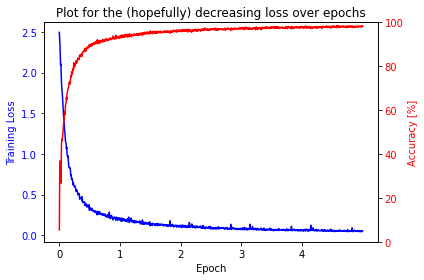

In [12]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
ax.plot(model.training_loss_, 'b-')
ax.set_ylabel("Training Loss", color='b')
ax.set_xlabel("Epoch")
# ax.set_yscale('log')
ax.tick_params(axis='y', labelcolor='b')
ax = ax.twinx()
ax.plot(model.training_accuracy_, 'r-')
ax.set_ylabel("Accuracy [%]", color='r')
ax.tick_params(axis='y', labelcolor='r')
a = list(ax.axis())
a[2] = 0
a[3] = 100
ax.axis(a)
t = np.arange(0, len(model.training_accuracy_), len(X_train)//batch_size+1)
ax.set_xticks(ticks=t)
ax.set_xticklabels(labels=np.arange(len(t)))
fig.tight_layout()
plt.show()

## Test data accuracy

This shows that the model sort of works. A per sentence accuracy would be better while being able to also analyse the predictions qualitatively would be best.

In [13]:
with torch.no_grad():                                                           # Do not use the following forward passes to calculate a gradient
  n_correct = 0
  n_total = 0
  for inputs, targets in batch_iterator(X_test, y_test, batch_size=batch_size): # Loop once over the test data
    scores = model(inputs)                                                      # Runs the test data through the model
    predictions = scores.argmax(dim=2, keepdim=True).squeeze()                  # Finds the predictions
    mask = targets!=tag2idx['<PAD>']                                            # Create a mask for ignoring <PAD> in the targets
    n_correct += (predictions[mask] == targets[mask]).sum().item()              # Sums the number of correct predictions
    n_total += mask.sum().item()
print("Test accuracy %.1f%%" % (100*n_correct/n_total))

Test accuracy 95.6%


1: The first thing I did was to make the LSMTM into a biLSTM by adding an extra parameter method and multiplying the  self.lstm_hidden_dim_ = lstm_hidden_dim argument by 2, and adding a bidirectional method. Surprisingly, the accuracy of the bidirectional model actually was lower than the simple forward LSTM; test accuracy went down to 95,6% from 91%. Disciss reasons why. 

2: I chose to add two languages from universal dependencies, Arabic and Norwegian bokmål. 